In [2]:
%pylab inline
%matplotlib inline

import os
os.chdir("/Users/Bya/git/predictEPL/MyFunctions/")
from dataIO import csv_dic_df

import time
import collections
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")
sys.path.append("/Users/Bya/git/predictEPL/WebScrapping/")

import paths
import espn_urls
import my_plot
import scrap_espn_gamecast
import emolex
import tokenizer

import useful_methods
from useful_methods import FolderFiles
from useful_methods import csv_dic_df
from useful_methods import FilterDF

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Read Soccer Emolex
%time dic_emolex_soccer = emolex.EmolexSoccerDic()

CPU times: user 579 ms, sys: 16.5 ms, total: 595 ms
Wall time: 638 ms


In [8]:
dic_emolex_stemmed_soccer = dic_emolex_soccer

In [5]:
# choosing data
week = str(13)
GW = 'GW' + week
filenames = FolderFiles(GW + '/SingleGames', paths.READ_PATH_EXTRACTED_CSV, ends='.csv')
filenames

['Chelsea_vs_Norwich.csv',
 'City_vs_Liverpool.csv',
 'Crystal_vs_Sunderland.csv',
 'Everton_vs_Villa.csv',
 'Newcastle_vs_Leicester.csv',
 'Southampton_vs_Stoke.csv',
 'Swansea_vs_Bournemouth.csv',
 'Tottenham_vs_WestHam.csv',
 'WestBromwich_vs_Arsenal.csv']

In [11]:
# Set Game
filename = filenames[1]

# Read DF
os.chdir(paths.READ_PATH_EXTRACTED_CSV + GW + '/SingleGames')
df = csv_dic_df(filename)

start_time = time.time()

# [Filter] DF
dfFilter = FilterDF(df)

# # [Filtered] All, Non-Retweet
# dfFilterEmolex = emolex.CreateEmolexDF(dfFilter, dic_emolex, dic_emolex_stemmed)
# dfFilterEmolexNonRetweet = emolex.CreateEmolexDF(dfFilter[dfFilter['status'] != 'retweet'], dic_emolex, dic_emolex_stemmed)

# # [Filtered] Home, Away
dfFilterEmolexSoccerHome = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'home'], dic_emolex_soccer)
dfFilterEmolexSoccerAway = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'away'], dic_emolex_soccer)

# # [Filtered, Non ReTweet] Home, Away
# dfFilterEmolexNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex)
# dfFilterEmolexNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex)

# [Filtered, Non ReTweet] Home, Away
dfFilterEmolexSoccerNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer)
dfFilterEmolexSoccerNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer)

print("[Done]: %.2f" % (time.time() - start_time))

[Done]: 3.16


In [9]:
# Scrap Gamecast
url = espn_urls.MatchUrl(GW, filename)
dfGameCast = scrap_espn_gamecast.CreateEspnLiveCommentDF(url)

# Create Goal, Attack, Foul dics
%time goals_dic, attacks_dic_home, attacks_dic_away, fouls_dic_home, fouls_dic_away = scrap_espn_gamecast.CreateGAFdics(dfGameCast)

[Match]: Manchester City VS Liverpool
[Scrap Done]: 31.09 sec
CPU times: user 10.3 ms, sys: 172 µs, total: 10.5 ms
Wall time: 10.6 ms


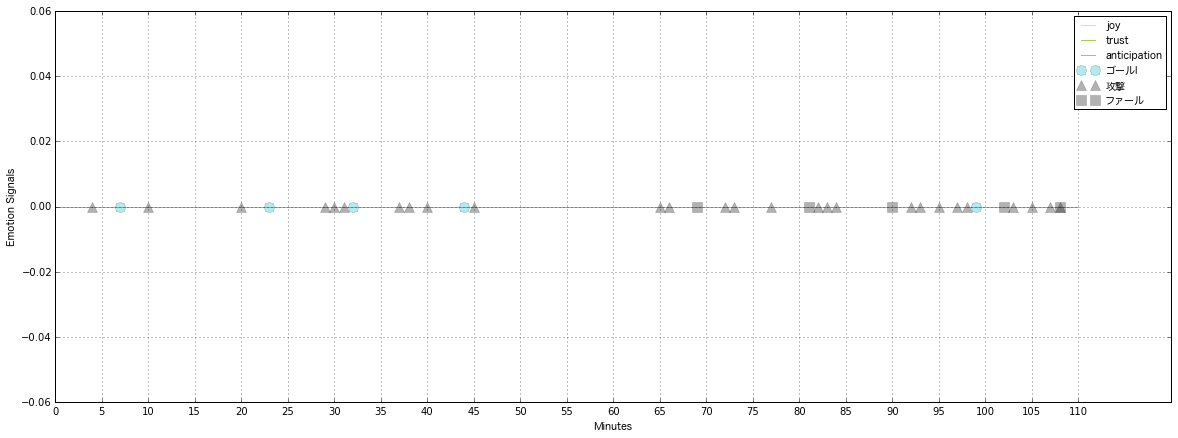

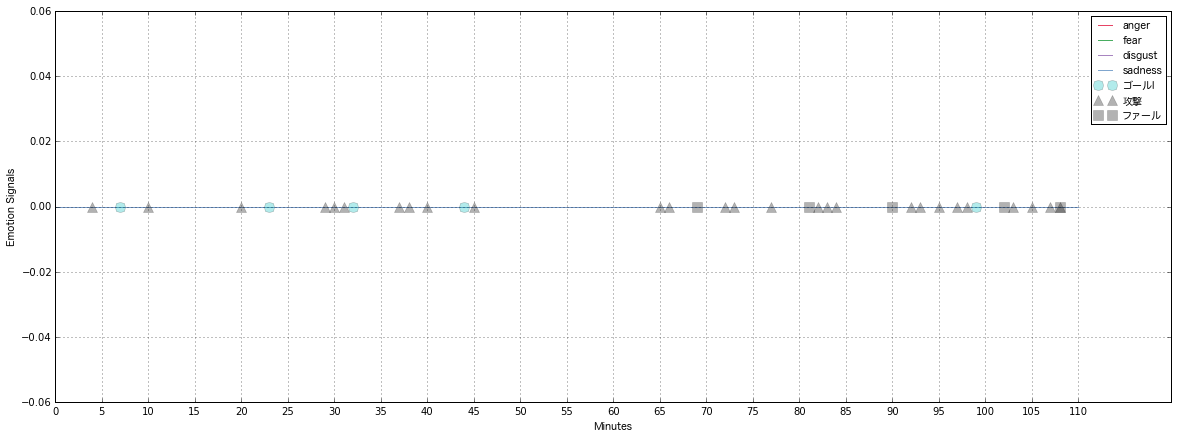

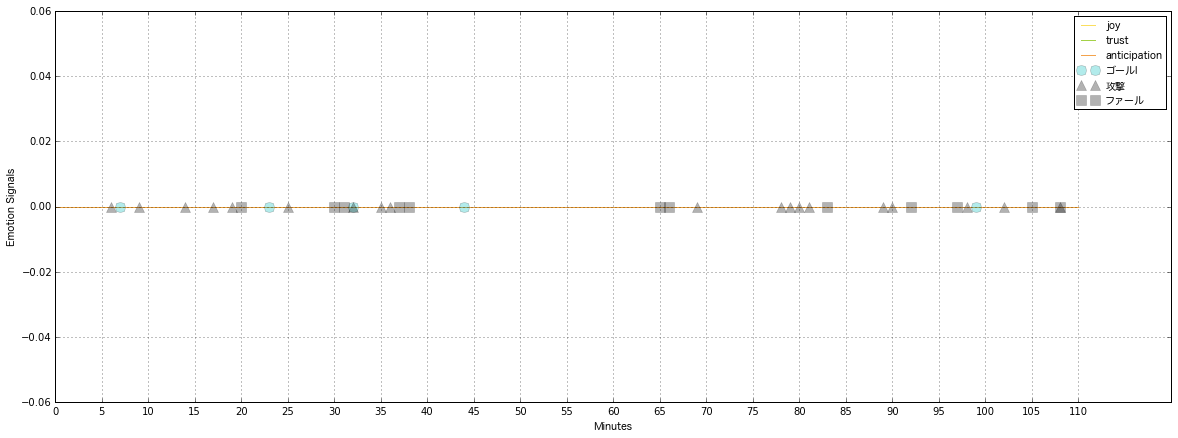

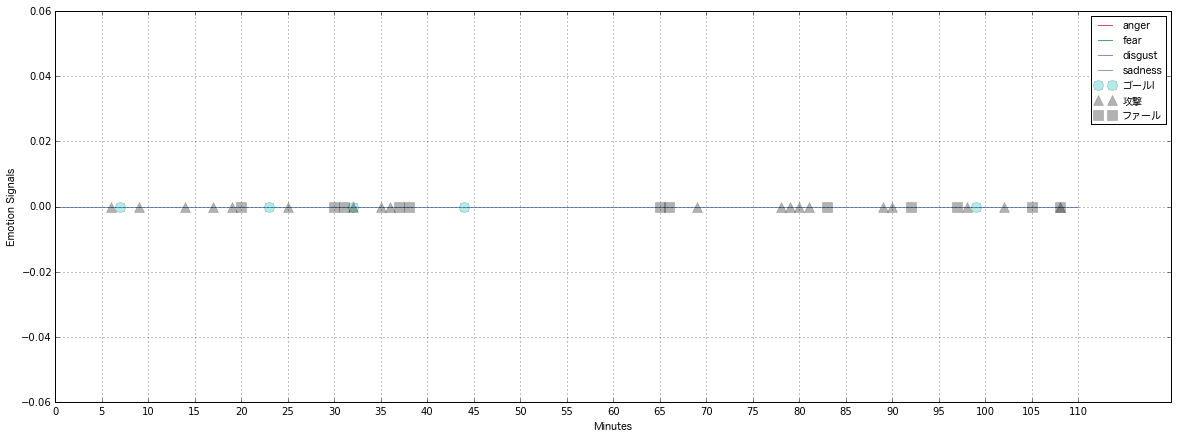

In [12]:
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtHome, goals_dic, attacks_dic_home, fouls_dic_home, title='Home')
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtAway, goals_dic, attacks_dic_away, fouls_dic_away, title='Away')

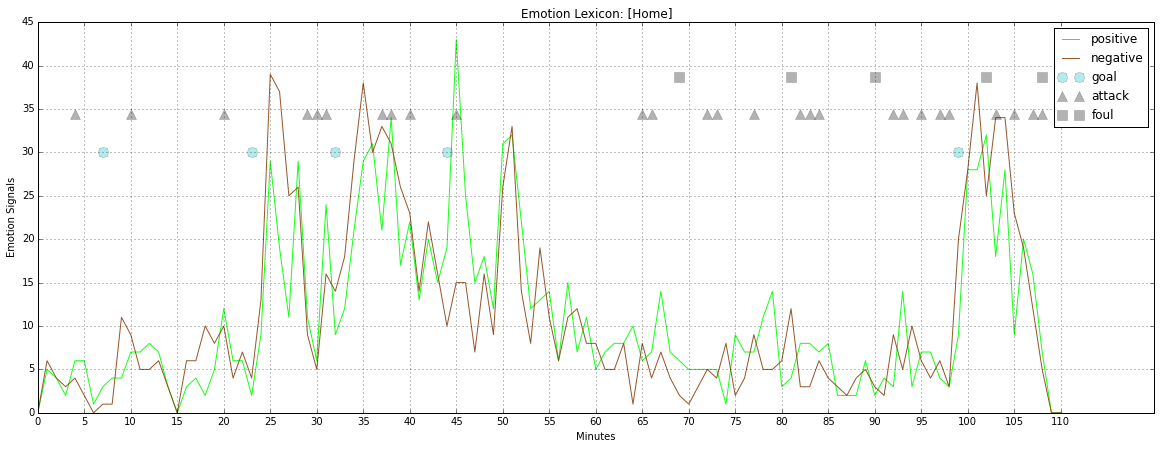

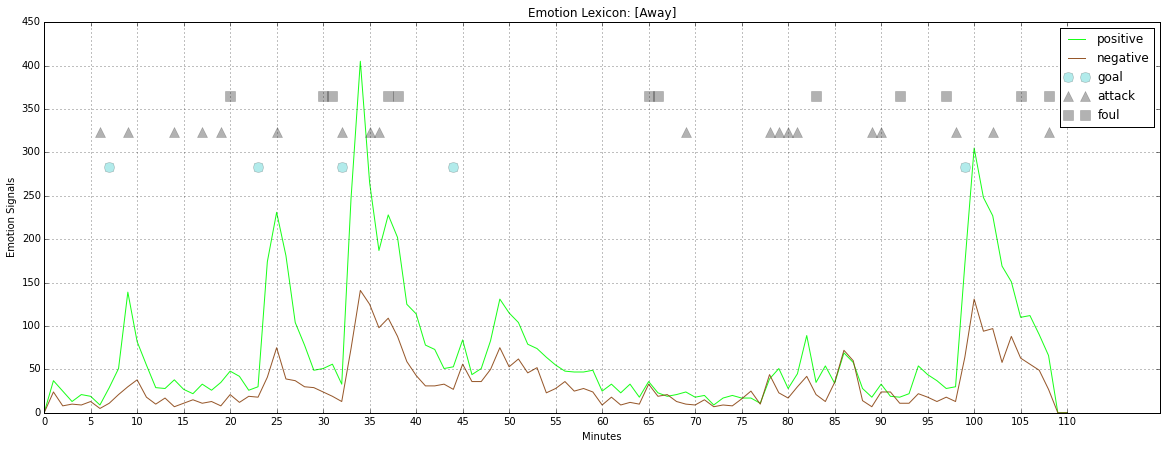

In [7]:
my_plot.EmolexCats(dfFilterEmolexSoccerNonRtHome, ['positive', 'negative'], goals_dic, attacks_dic_home, fouls_dic_home, 'Home')
my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

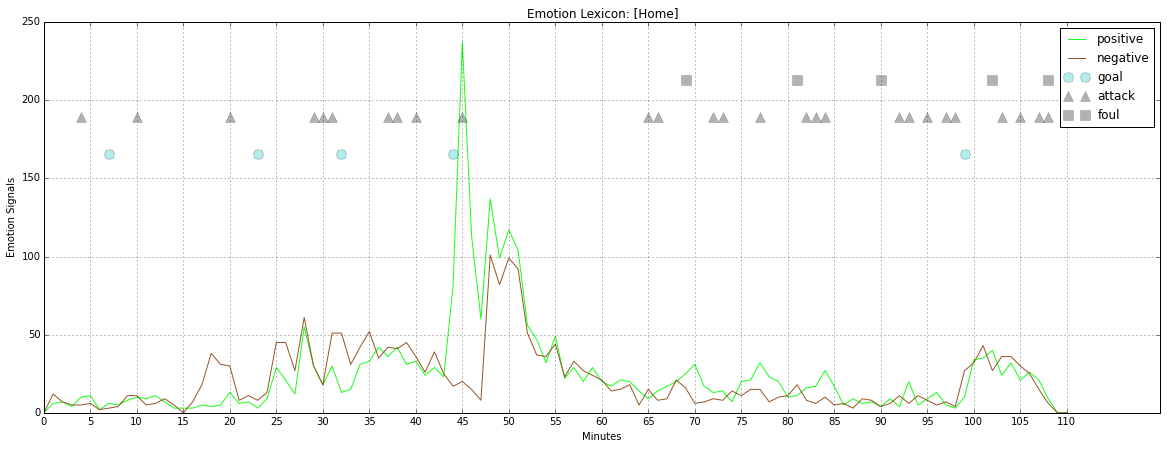

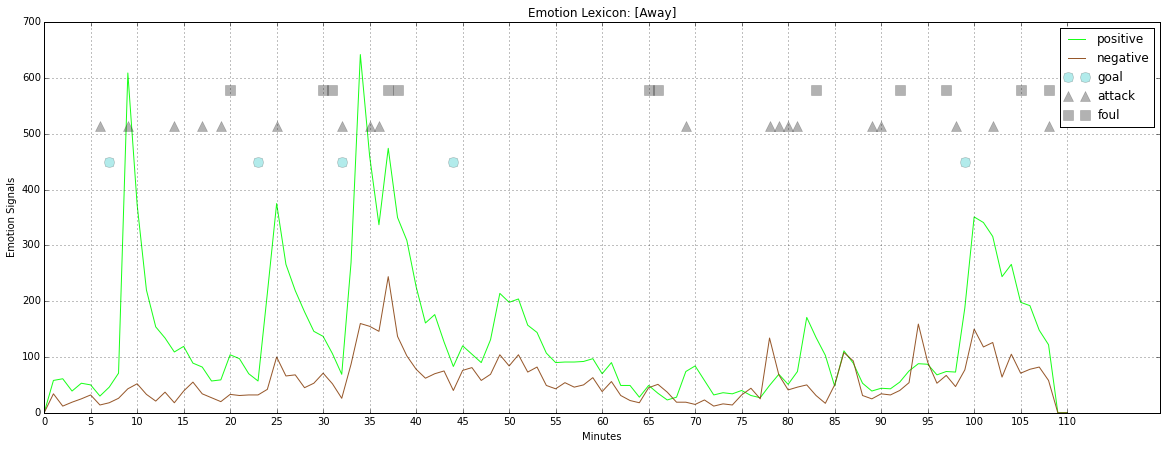

In [8]:
my_plot.EmolexCats(dfFilterEmolexSoccerHome, ['positive', 'negative'], goals_dic, attacks_dic_home, fouls_dic_home, 'Home')
my_plot.EmolexCats(dfFilterEmolexSoccerAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# Words Examination

In [13]:
# Set minute and side
start_minute = 99
end_minute = 110
side = 'home'

dfExamine = dfFilter.copy()
dfExamine['ith_minute'] = [int(ith_minte) for ith_minte in dfExamine['ith_minute']]

# extract tweets
tweets = list(dfExamine[
        (dfExamine['side'] == side) &
        (dfExamine['status'] != 'retweet') &
        (dfExamine['ith_minute'] >= start_minute) &
        (dfExamine['ith_minute'] <= end_minute)
    ]['text'])

print("[Tweets Number]: %s\n" % len(tweets))

# Create words lists. PreprocessingTweet
start_time = time.time()
all_words = []
all_words_stemmend = []
for tweet in tweets:
    words = tokenizer.TweetLemmaSoccerLemma(tweet)
    all_words += words

print("[All Words]: %s" % (len(all_words)))
print("[Unique Words]: %s\n" % (len(set(all_words))))

print("[Most Common 10 Words]:")
useful_methods.ShowMostCommon(all_words)
print("\n")

print("[Emolex Words Count]:")
pprint(emolex.CountEmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words, all_words_stemmend))
print("\n")


print("[Passed Time]: %.2f sec" % (time.time() - start_time))

[Tweets Number]: 447

[All Words]: 3927
[Unique Words]: 1496

[Most Common 10 Words]:
[('mcfc', 315),
 ('mancity', 122),
 ('liverpool', 112),
 ("'s", 45),
 ('fan', 42),
 ('4-1', 33),
 ('today', 32),
 ('game', 28),
 ('manchestercity', 26),
 ('well', 24)]


[Emolex Words Count]:
{'anger': 118,
 'anticipation': 106,
 'disgust': 104,
 'fear': 104,
 'joy': 100,
 'negative': 238,
 'positive': 195,
 'sadness': 139,
 'surprise': 65,
 'trust': 122}


[Passed Time]: 0.59 sec


In [10]:
cat = 'positive'

emolex_words = emolex.EmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words)

cat_words = emolex_words[cat]
useful_methods.ShowMostCommon(cat_words, 20)
len(cat_words)

[('love', 129),
 ('good', 101),
 ('brilliant', 62),
 ('happy', 58),
 ('beauty', 54),
 ('top', 50),
 ('beautiful', 41),
 ('absolute', 32),
 ('pick', 27),
 ('deserved', 26),
 ('outstanding', 26),
 ('god', 26),
 ('winning', 25),
 ('holy', 22),
 ('hope', 21),
 ('proud', 19),
 ('full', 17),
 ('sensational', 16),
 ('loving', 16),
 ('money', 16)]


1649

In [ ]:
dic_emolex_soccer['lead']

In [16]:
for tweet in tweets:
    if ' good' in tweet:
#         print("\n---------")
#         print(tweet, '\n\n')
        neg_text = tokenizer.NegationMark(tweet)
        if neg_text:
            print("\n---------")
            print(tweet, '\n\n')
            print(neg_text, '\n')
#         print(emolex.CountEmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer,
#                                           tokenizer.TweetLemmaSoccerLemma(tweet)))


---------
Massively unimpressed by City today. Just don't look good enough to win anything. #mcfc 


massively unimpressed by city today. just don't look_NEG good_NEG enough_NEG to_NEG win_NEG anything_NEG. #mcfc. 


---------
@StanCollymore @talkSPORT One swallow does not make a summer. Liverpool need consistent results as well very good ones. #Liverpool #ManCity 


@stancollymore @talksport one swallow does not_NEG make_NEG a_NEG summer_NEG. liverpool need consistent results as well very good ones. #liverpool #mancity. 


---------
It was never going to happen today. Liverpool has looked really good and we looked really bad  #mcfc 


it was never_NEG going_NEG to_NEG happen_NEG today_NEG. liverpool has looked really good and we looked really bad  #mcfc. 


---------
Well done Liverpool, done a job on us 2day. Pellegrini naive tonight. Game lost in 1st half. Certain back up players not good enough. #mcfc 


well done liverpool, done a job on us 2day. pellegrini naive tonight. game lo